### Notebook experiment for predominant colors extraction given input images 

In [ ]:
import cv2
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
from urllib.parse import urlparse
from io import BytesIO

In [4]:
class ColorAnalyzer:
    '''
    This class analyzes the predominant colors in an image 
    using K-Means clustering based on the RGB color paradigm.
    
    Attributes:
        url_or_path (str): The URL or local file path of the image.
        num_clusters (int): The number of clusters to identify as predominant colors.
        scaling_factor (int): The percentage by which to scale the image for preprocessing.
        image (numpy.ndarray): The loaded and preprocessed image.
        pixels (numpy.ndarray): Reshaped image data for clustering.
        image_rgb (numpy.ndarray): Resized image in RGB format.
        centroids (numpy.ndarray): Centroids (predominant colors) obtained through clustering.
        percentages (numpy.ndarray): Percentage of pixels belonging to each cluster.
        labels (numpy.ndarray): Labels indicating cluster membership for each pixel.
        sorted_colors (numpy.ndarray): Predominant colors sorted by cluster size.
        sorted_percentages (numpy.ndarray): Percentages of pixels per cluster, sorted by cluster size.
    '''
    def __init__(self, url_or_path, num_clusters=4, scaling_factor=10):
        '''
        Initializes the ImageColorAnalyzer with the provided parameters.

        Args:
            url_or_path (str): The URL or local file path of the image.
            num_clusters (int, optional): The number of clusters to identify as predominant colors (default is 5).
            scaling_factor (int, optional): The percentage by which to scale the image for preprocessing (default is 10).
        '''
        self.url_or_path = url_or_path
        self.num_clusters = num_clusters
        self.scaling_factor = scaling_factor
        self.image = self.load_image()
        self.pixels, self.image_rgb = self.preprocess_image()
        self.centroids, self.percentages, self.labels = self.find_clusters()
        self.sorted_colors, self.sorted_percentages = self.sort_clusters_by_size()


    def load_image(self):
        '''
        Load the image into a 2D array from the local path or URL.
        
        Returns:
            numpy.ndarray: The loaded image.
        
        Raises:
            Exception: If the URL does not exist or is broken, or if the image path is invalid.
        '''
        # If the input image path is a URL 
        if self.is_url():
            
            # Get the response
            response = requests.get(self.url_or_path)
            
            # If there is a problem in getting the response..
            if response.status_code != 200:
                
                # ..raise an exception
                raise Exception('URL does not exist or it is broken.')
            
            # Try to extract the image from the URL
            try:
                
                # Get PIL image object file from the response 
                image = Image.open(BytesIO(response.content))
                
                # Convert image from PIL to OpenCV format
                image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
            
            # If an error occurs in processing the URL..
            except:
                
                # ..raise an exception
                raise Exception('URL may not contain an image.')
        
        # If the input image path is not a URL
        else:
            
            # Try to load the image
            try:
                
                # Load the image from a local path
                image = cv2.imread(self.url_or_path)
            
            # If there is a problem reading the local path..
            except:
                
                # ..raise an exception
                raise Exception('Invalid image path.')
        
        # return the loaded image
        return image


    def is_url(self):
        '''
        Check if the input path is URL.
        
        Returns:
            bool: True if the path is a URL, False otherwise.
        '''
        # Return True if the path is a URL, False otherwise
        return 'http' in urlparse(self.url_or_path).scheme

    
    def preprocess_image(self):
        '''
        Resize the image to improve processing speed.
        
        Returns:
            tuple: 
                Resized image data for clustering
                Image for plotting.
        '''
        # Resize the image by the scaling factor for performances
        width = int(self.image.shape[1] * self.scaling_factor / 100)
        height = int(self.image.shape[0] * self.scaling_factor / 100)
        resized_img = cv2.resize(
            self.image, (width, height), interpolation=cv2.INTER_AREA)
        
        # Convert the image back to RGB
        image_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        
        # Extract pixels as 2D array for clustering
        pixels = image_rgb.reshape(-1, 3)
        
        # Return array for clustering and image for plotting
        return pixels, image_rgb

    
    def find_clusters(self):
        '''
        Find predominant colors through clustering.
        
        Returns:
            tuple: 
                centroids (predominant colors)
                percentages of pixels per cluster
                labels of each point.           
        '''
        # Get 2D array
        pixels, _ = self.preprocess_image()

        # Instantiate clustering model
        kmeans = KMeans(n_clusters=self.num_clusters, n_init=10)
        
        # Fit the model on the image and get labels
        labels = kmeans.fit_predict(pixels)
        
        # Get centroids (predominant colors)
        centroids = kmeans.cluster_centers_.round(0).astype(int)
        
        # Get percentage of pixels belonging to each cluster
        percentages = np.bincount(labels) / len(pixels) * 100

        # Return:
        #   - centroids 
        #   - percentage of pixels per cluster        
        #   - labels of each point
        return centroids, percentages, labels
    
    
    def sort_clusters_by_size(self):
        '''
        Sort predominant colors and percentages 
        of pixels per cluster by cluster size 
        in descending order.
        
        Returns:
            tuple: 
                Predominant colors sorted by cluster size
                Percentages of pixels per cluster sorted by cluster size.
        '''
        sorted_indices = np.argsort(self.percentages)[::-1]
        sorted_colors = self.centroids[sorted_indices]
        sorted_percentages = self.percentages[sorted_indices]
        return sorted_colors, sorted_percentages


    def plot_image(self):
        '''
        Plot the preprocessed image (resized).
        '''
        plt.imshow(self.image_rgb)
        plt.title('Preprocessed Image')
        plt.axis('off')
        plt.show()


    def plot_3d_clusters(self, width=15, height=12):
        '''
        Plot a 3D visualization of the clustering.
        
        Args:
            width (int, optional): Width of the plot (default is 15).
            height (int, optional): Height of the plot (default is 12).
        '''
        # Prepare figure
        fig = plt.figure(figsize=(width, height))
        ax = fig.add_subplot(111, projection='3d')

        # Plot point labels with their cluster's color
        for label, color in zip(np.unique(self.labels), self.centroids):
            cluster_pixels = self.pixels[self.labels == label]
            r, g, b = color
            ax.scatter(cluster_pixels[:, 0], 
                       cluster_pixels[:, 1], 
                       cluster_pixels[:, 2], 
                       c=[[r/255, g/255, b/255]],  
                       label=f'Cluster {label+1}')

        # Display title, axis labels and legend
        ax.set_title('3D Cluster Visualization')
        ax.set_xlabel('r')
        ax.set_ylabel('g')
        ax.set_zlabel('b')
        plt.legend()
        plt.show()


    def plot_predominant_colors(self, width=12, height=8):
        '''
        Plot a bar chart of predominant colors 
        ordered by presence in the picture.
        
        Args:
            width (int, optional): Width of the plot (default is 12).
            height (int, optional): Height of the plot (default is 8).
        '''
        # Prepare color labels for the plot
        color_labels = [f'Color {i+1}' for i in range(self.num_clusters)]
        
        # Prepare figure
        plt.figure(figsize=(width, height))
        
        # Plot bars
        bars = plt.bar(color_labels, 
                       self.sorted_percentages, 
                       color=self.sorted_colors / 255.0, 
                       edgecolor='black')

        # Add percentage of each bar on the plot
        for bar, percentage in zip(bars, 
                                   self.sorted_percentages):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(), 
                f'{percentage:.2f}%', 
                ha='center', 
                va='bottom')

        # Display title and axis labels
        plt.title(f'Top {self.num_clusters} Predominant Colors')
        plt.xlabel('Colors')
        plt.ylabel('Percentage of Pixels')
        plt.xticks(rotation=45)
        plt.show()
        
        
    def get_predominant_colors(self):
        '''
        Return a list of predominant colors.
        Each color is a JSON object with RGB code and percentage.
        '''
        # Prepare output list
        colors_json = []
        
        # For each predominant color
        for color, percentage in zip(self.sorted_colors, 
                                     self.sorted_percentages):
            # Get the RGB code
            r, g, b = color
            
            # Prepare JSON object
            color_entry = {'color': {'R': f'{r}', 
                                     'G': f'{g}', 
                                     'B': f'{b}'}, 
                           'percentage': f'{percentage:.2f}%'}
            
            # Append JSON object to color list
            colors_json.append(color_entry)

        # Return the results
        return colors_json

### Usage

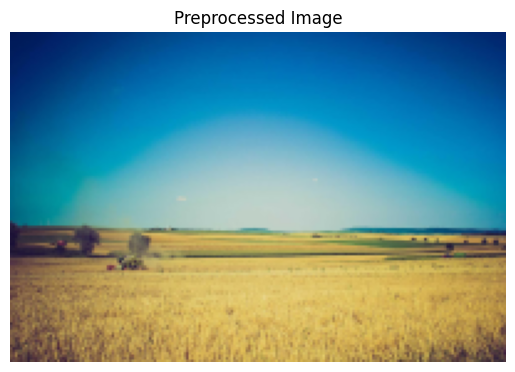

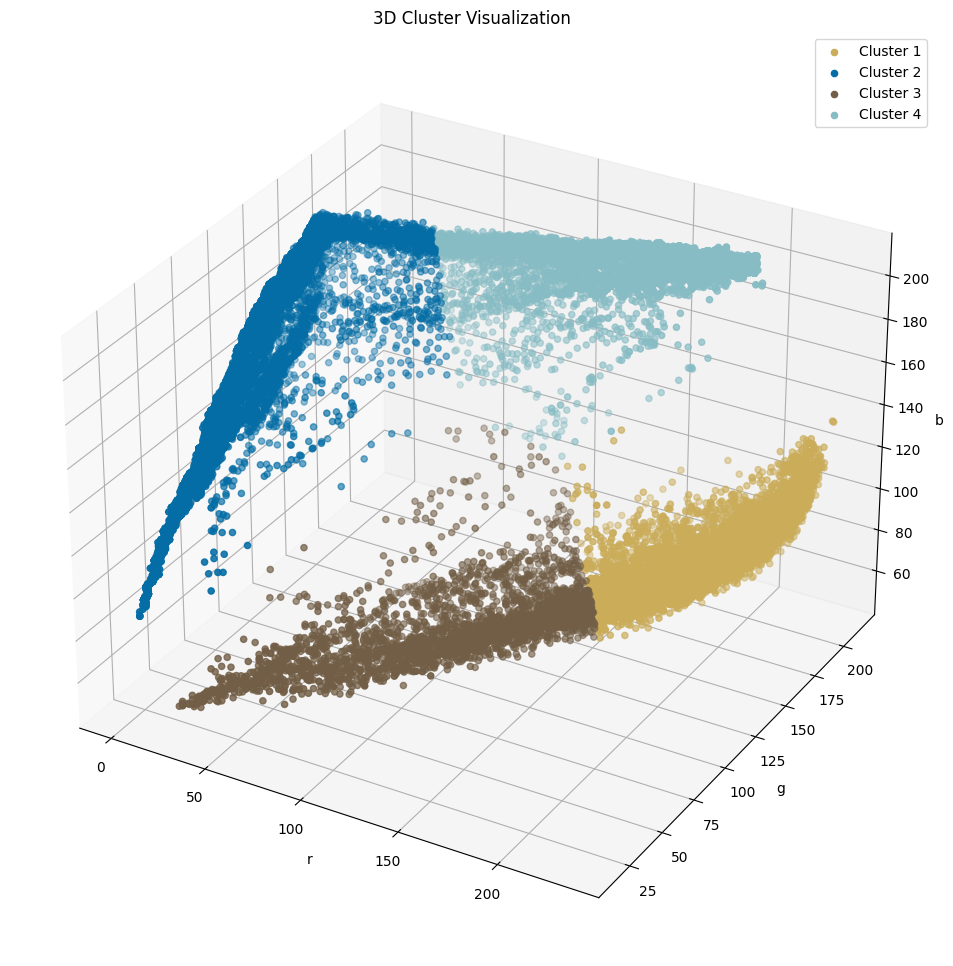

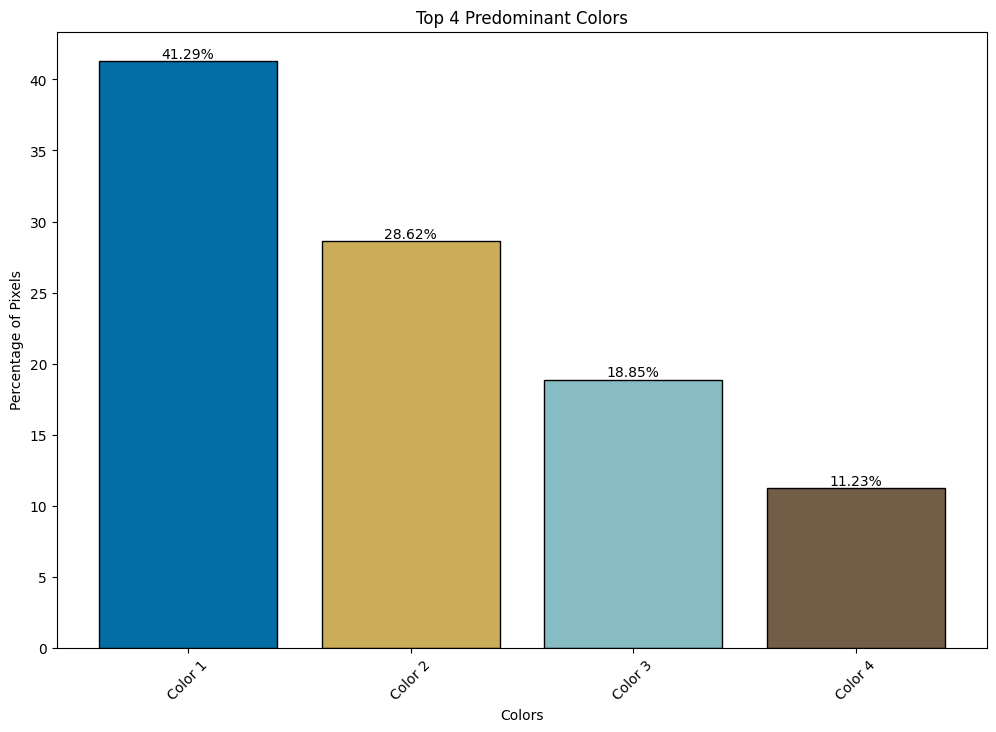

[
   {
      "color": {
         "R": "4",
         "G": "109",
         "B": "165"
      },
      "percentage": "41.29%"
   },
   {
      "color": {
         "R": "202",
         "G": "172",
         "B": "89"
      },
      "percentage": "28.62%"
   },
   {
      "color": {
         "R": "135",
         "G": "188",
         "B": "196"
      },
      "percentage": "18.85%"
   },
   {
      "color": {
         "R": "114",
         "G": "94",
         "B": "70"
      },
      "percentage": "11.23%"
   }
]


In [5]:
# Request color extraction for an image URL 
colors_extractor = ColorAnalyzer(
    'https://fastly.picsum.photos/id/165/2000/1333.jpg?hmac=KK4nT-Drh_vgMxg3hb7rOd6peHRIYmxMg0IEyxlTVFg', 
    num_clusters=4)

# Plot resized original image
colors_extractor.plot_image()

# 3D plot of the centroids and data points
colors_extractor.plot_3d_clusters()

# Bar chart of predominant colors
colors_extractor.plot_predominant_colors()

# Predominant colors as list of JSON
print(json.dumps(
    colors_extractor.get_predominant_colors(), 
    indent=3)
)

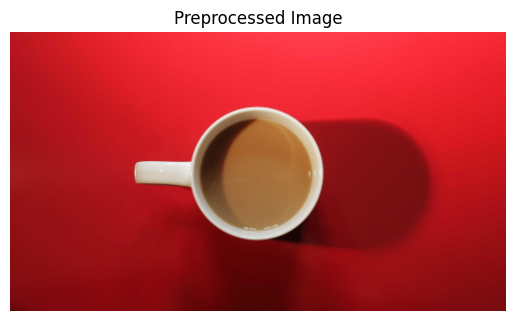

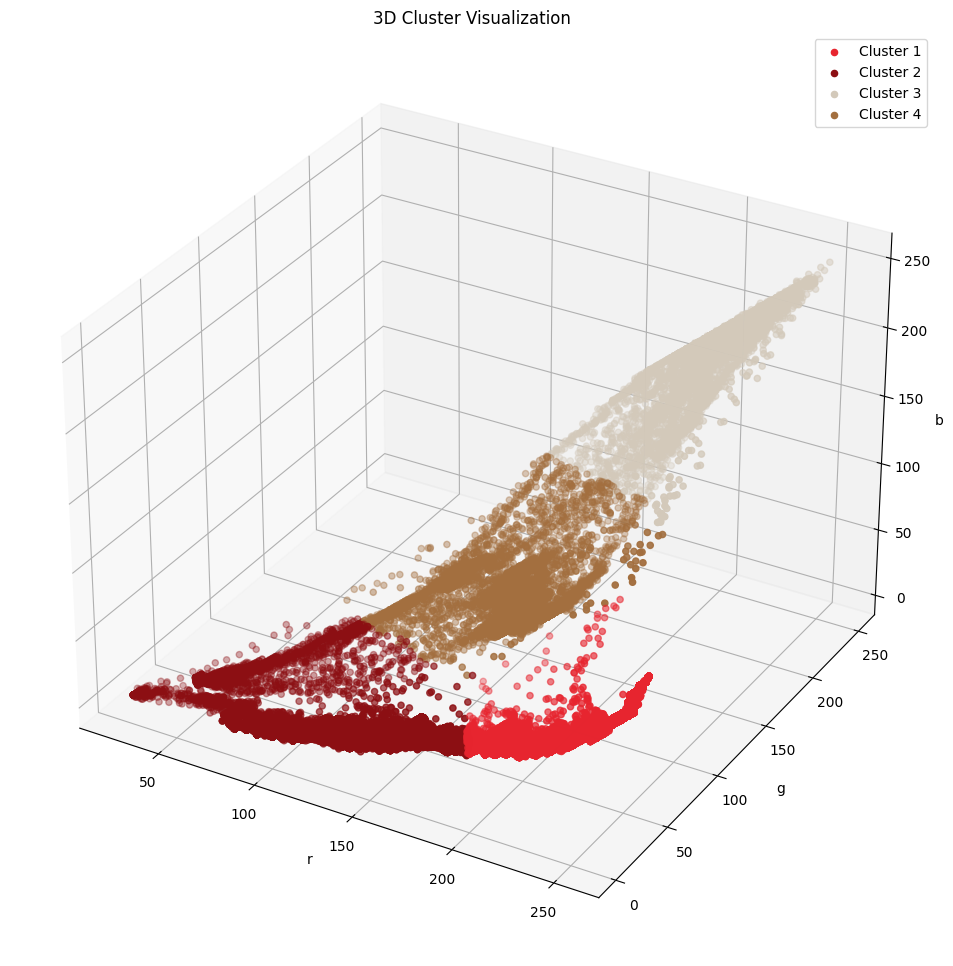

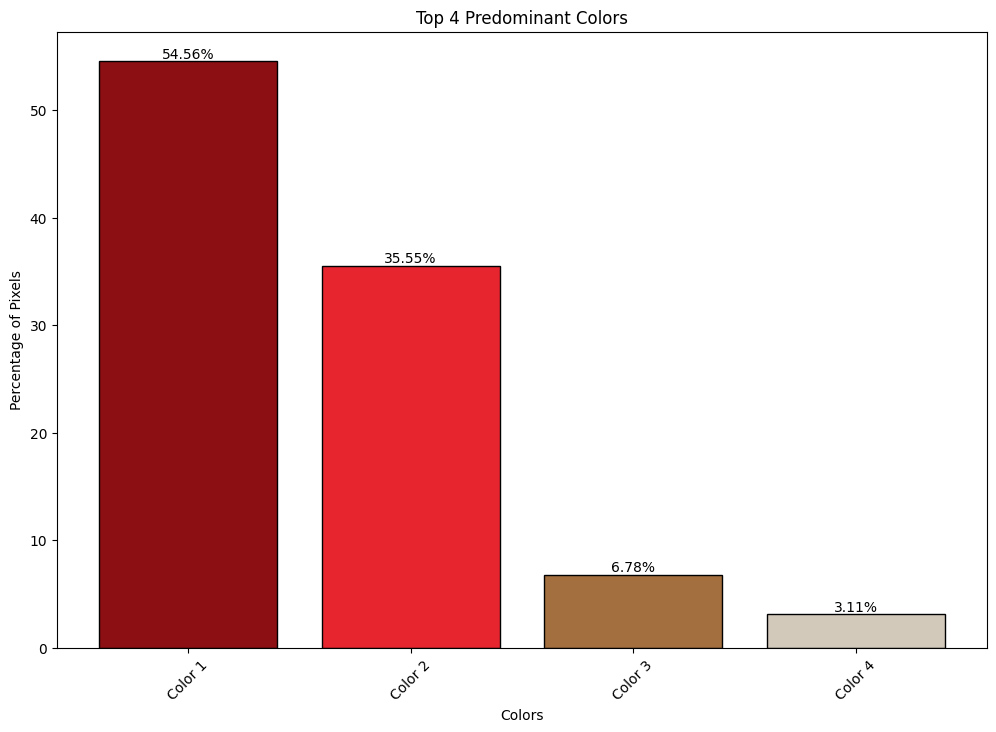

[
   {
      "color": {
         "R": "140",
         "G": "15",
         "B": "19"
      },
      "percentage": "54.56%"
   },
   {
      "color": {
         "R": "231",
         "G": "37",
         "B": "47"
      },
      "percentage": "35.55%"
   },
   {
      "color": {
         "R": "163",
         "G": "111",
         "B": "63"
      },
      "percentage": "6.78%"
   },
   {
      "color": {
         "R": "211",
         "G": "201",
         "B": "186"
      },
      "percentage": "3.11%"
   }
]


In [6]:
# Request color extraction for an image URL 
colors_extractor = ColorAnalyzer(
    'https://fastly.picsum.photos/id/63/5000/2813.jpg?hmac=HvaeSK6WT-G9bYF_CyB2m1ARQirL8UMnygdU9W6PDvM', 
    num_clusters=4)

# Plot resized original image
colors_extractor.plot_image()

# 3D plot of the centroids and data points
colors_extractor.plot_3d_clusters()

# Bar chart of predominant colors
colors_extractor.plot_predominant_colors()

# Predominant colors as JSON
print(json.dumps(
    colors_extractor.get_predominant_colors(), 
    indent=3)
)

#### Disclaimer on the license for the data being used

For this post, we used two images from the web:
- "[Brown grass field background of mountain view](https://unsplash.com/photos/xjXz8GKXcTI)" by [Linh Nguyen](https://unsplash.com/@bylinhnguyen).
- "[White ceramic mug filled with coffee](https://unsplash.com/photos/ZJsseAxEcqM)" by [Justin Leibow](https://unsplash.com/@justinleibow).

The provided links state that both images are free to use for personal and commercial use under the [Unplash license](https://unsplash.com/license). 

We generated image URLs using [Picsum](https://picsum.photos/) ([GitHub repo](https://github.com/DMarby/picsum-photos)) available under the [MIT license](https://github.com/DMarby/picsum-photos/blob/main/LICENSE.md).